<a href="https://colab.research.google.com/github/LogikerKit/MuellerConeFilter/blob/master/assets/hub/nvidia_deeplearningexamples_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook requires a GPU runtime to run.
### Please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# EfficientNet

*Author: NVIDIA*

**EfficientNets are a family of image classification models, which achieve state-of-the-art accuracy, being an order-of-magnitude smaller and faster. Trained with mixed precision using Tensor Cores.**

<img src="https://pytorch.org/assets/images/classification.jpg" alt="alt" width="50%"/>



### Model Description

EfficientNet is an image classification model family. It was first described in [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946). This notebook allows you to load and test the EfficientNet-B0, EfficientNet-B4, EfficientNet-WideSE-B0 and, EfficientNet-WideSE-B4 models.

EfficientNet-WideSE models use Squeeze-and-Excitation layers wider than original EfficientNet models, the width of SE module is proportional to the width of Depthwise Separable Convolutions instead of block width.

WideSE models are slightly more accurate than original models.

This model is trained with mixed precision using Tensor Cores on Volta and the NVIDIA Ampere GPU architectures. Therefore, researchers can get results over 2x faster than training without Tensor Cores, while experiencing the benefits of mixed precision training. This model is tested against each NGC monthly container release to ensure consistent accuracy and performance over time.

We use [NHWC data layout](https://pytorch.org/tutorials/intermediate/memory_format_tutorial.html) when training using Mixed Precision.

### Example

In the example below we will use the pretrained ***EfficientNet*** model to perform inference on image and present the result.

To run the example you need some extra python packages installed. These are needed for preprocessing images and visualization.

In [7]:
!pip install validators matplotlib
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.5 MB/s 


In [18]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

import torch
from PIL import Image
from torchvision.transforms import ToTensor
img0 = torch.zeros(1,3,64,64) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = torch.zeros(1,3,64,64)
d = loss_fn_alex(img0, img1)
print(d)

Using cpu for inference
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth
tensor([[[[0.]]]], grad_fn=<AddBackward0>)


Load the model pretrained on IMAGENET dataset.

You can choose among the following models:

| TorchHub entrypoint | Description |
| :----- | :----- |
| `nvidia_efficientnet_b0` | baseline EfficientNet |
| `nvidia_efficientnet_b4` | scaled EfficientNet|
| `nvidia_efficientnet_widese_b0` | model with Squeeze-and-Excitation layers wider than baseline EfficientNet model |
| `nvidia_efficientnet_widese_b4` | model with Squeeze-and-Excitation layers wider than scaled EfficientNet model |

There are also quantized version of the models, but they require nvidia container. See [quantized models](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Classification/ConvNets/efficientnet#quantization)

In [9]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

efficientnet.eval().to(device)


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

Prepare sample input data.

In [4]:
uris = [
    'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000028117.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000006149.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000004954.jpg',
]

batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)


Run inference. Use `pick_n_best(predictions=output, n=topN)` helper function to pick N most probable hypotheses according to the model.

In [5]:
with torch.no_grad():
    output = torch.nn.functional.softmax(efficientnet(batch), dim=1)
    
results = utils.pick_n_best(predictions=output, n=5)

sample 0: [('laptop, laptop computer', '49.9%'), ('notebook, notebook computer', '36.2%'), ('desk', '3.7%'), ('mouse, computer mouse', '0.5%'), ('space bar', '0.5%')]
sample 1: [('mashed potato', '87.0%'), ('meat loaf, meatloaf', '5.2%'), ('broccoli', '1.9%'), ('plate', '0.3%'), ('guacamole', '0.1%')]
sample 2: [('racket, racquet', '55.8%'), ('tennis ball', '8.4%'), ('ping-pong ball', '2.6%'), ('golf ball', '0.6%'), ('baseball', '0.6%')]
sample 3: [('kelpie', '52.7%'), ('malinois', '4.1%'), ('groenendael', '3.0%'), ('schipperke', '3.0%'), ('Scottish deerhound, deerhound', '2.6%')]


Display the result.

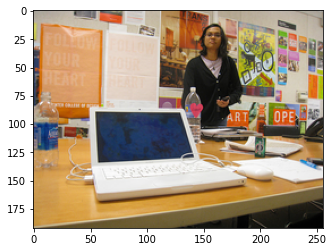

[('laptop, laptop computer', '49.9%'), ('notebook, notebook computer', '36.2%'), ('desk', '3.7%'), ('mouse, computer mouse', '0.5%'), ('space bar', '0.5%')]


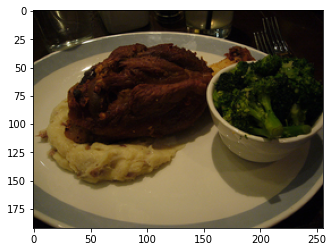

[('mashed potato', '87.0%'), ('meat loaf, meatloaf', '5.2%'), ('broccoli', '1.9%'), ('plate', '0.3%'), ('guacamole', '0.1%')]


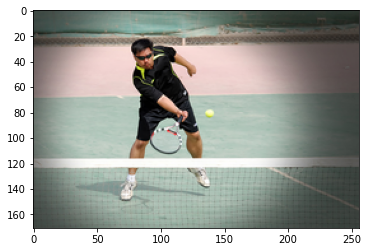

[('racket, racquet', '55.8%'), ('tennis ball', '8.4%'), ('ping-pong ball', '2.6%'), ('golf ball', '0.6%'), ('baseball', '0.6%')]


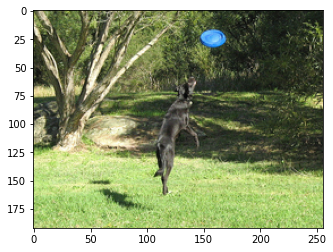

[('kelpie', '52.7%'), ('malinois', '4.1%'), ('groenendael', '3.0%'), ('schipperke', '3.0%'), ('Scottish deerhound, deerhound', '2.6%')]


In [22]:
for uri, result in zip(uris, results):
    img = Image.open(requests.get(uri, stream=True).raw)
    img.thumbnail((256,256), Image.ANTIALIAS)
    plt.imshow(img)
    plt.show()
    print(result)

In [23]:

img1=Image.open(requests.get(uris[0], stream=True).raw)
img1.thumbnail((256,256), Image.ANTIALIAS)
print(type(img1))
img1=ToTensor()(img1).unsqueeze(0)
img2=Image.open(requests.get(uris[1], stream=True).raw)
img2.thumbnail((256,256), Image.ANTIALIAS)
img2=ToTensor()(img2).unsqueeze(0)
print(loss_fn_alex(img1,img2))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
tensor([[[[0.6132]]]], grad_fn=<AddBackward0>)


### Details
For detailed information on model input and output, training recipies, inference and performance visit:
[github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Classification/ConvNets/efficientnet)
and/or [NGC](https://ngc.nvidia.com/catalog/resources/nvidia:efficientnet_for_pytorch)

### References

 - [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)
 - [model on NGC](https://ngc.nvidia.com/catalog/resources/nvidia:efficientnet_for_pytorch)
 - [model on github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Classification/ConvNets/efficientnet)
 - [pretrained model on NGC (efficientnet-b0)](https://ngc.nvidia.com/catalog/models/nvidia:efficientnet_b0_pyt_amp)
 - [pretrained model on NGC (efficientnet-b4)](https://ngc.nvidia.com/catalog/models/nvidia:efficientnet_b4_pyt_amp)
 - [pretrained model on NGC (efficientnet-widese-b0)](https://ngc.nvidia.com/catalog/models/nvidia:efficientnet_widese_b0_pyt_amp)
 - [pretrained model on NGC (efficientnet-widese-b4)](https://ngc.nvidia.com/catalog/models/nvidia:efficientnet_widese_b4_pyt_amp)
 - [pretrained, quantized model on NGC (efficientnet-widese-b0)](https://ngc.nvidia.com/catalog/models/nvidia:efficientnet_widese_b0_pyt_amp)
 - [pretrained, quantized model on NGC (efficientnet-widese-b4)](https://ngc.nvidia.com/catalog/models/nvidia:efficientnet_widese_b4_pyt_amp)